In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

In [3]:
#####train
trn_click = pd.read_csv('train_click_log.csv')
#trn_click = pd.read_csv(path+'train_click_log.csv', names=['user_id','item_id','click_time','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type'])
item_df = pd.read_csv('articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
item_emb_df = pd.read_csv('articles_emb.csv')

#####test
tst_click = pd.read_csv('testA_click_log.csv')

In [7]:
trn_click 


,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank
0,199999,160417,1507029570190,4,1,17,1,13,1,11
1,199999,5408,1507029571478,4,1,17,1,13,1,10
2,199999,50823,1507029601478,4,1,17,1,13,1,9
3,199998,157770,1507029532200,4,1,17,1,25,5,40
4,199998,96613,1507029671831,4,1,17,1,25,5,39
5,199998,144978,1507029804858,4,1,17,1,25,5,38
6,199998,285371,1507029834858,4,1,17,1,25,5,37
7,199997,224171,1507029683061,4,1,17,1,16,1,2
8,199997,223931,1507029713061,4,1,17,1,16,1,1
9,199996,299697,1507029600494,4,1,17,1,25,2,13


In [5]:
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

In [8]:
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

In [11]:
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id_x,created_at_ts_x,words_count_x,category_id_y,created_at_ts_y,words_count_y
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185,209,1506938444000,185
5,199998,144978,1507029804858,4,1,17,1,25,5,38,40,269,1506695631000,181,269,1506695631000,181
6,199998,285371,1507029834858,4,1,17,1,25,5,37,40,412,1506663059000,166,412,1506663059000,166
7,199997,224171,1507029683061,4,1,17,1,16,1,2,2,354,1507013963000,156,354,1507013963000,156
8,199997,223931,1507029713061,4,1,17,1,16,1,1,2,354,1506794753000,193,354,1506794753000,193
9,199996,299697,1507029600494,4,1,17,1,25,2,13,13,428,1506984684000,176,428,1506984684000,176


In [10]:
trn_click.click_cnts.min()

2

<AxesSubplot:>

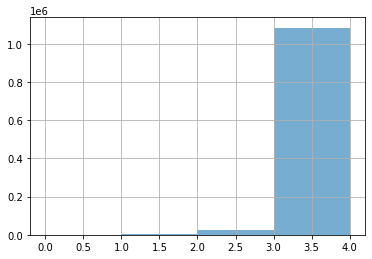

In [40]:
trn_click['click_environment'].hist(bins = range(0, 5, 1), histtype="bar", rwidth=1, alpha=0.6)

(array([      0.,    2102.,   25894., 1084627.]),
 array([0, 1, 2, 3, 4]),
 <BarContainer object of 4 artists>)

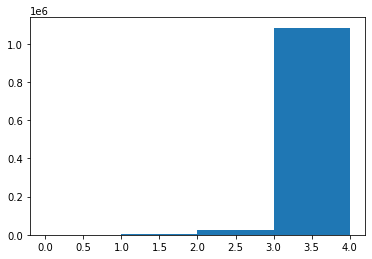

In [45]:
plt.hist(trn_click['click_environment'], bins=range(0, 5, 1) )

   index  click_deviceGroup
0      1             678187
1      3             395558
2      4              38731
3      5                141
4      2                  6


<Figure size 432x288 with 0 Axes>

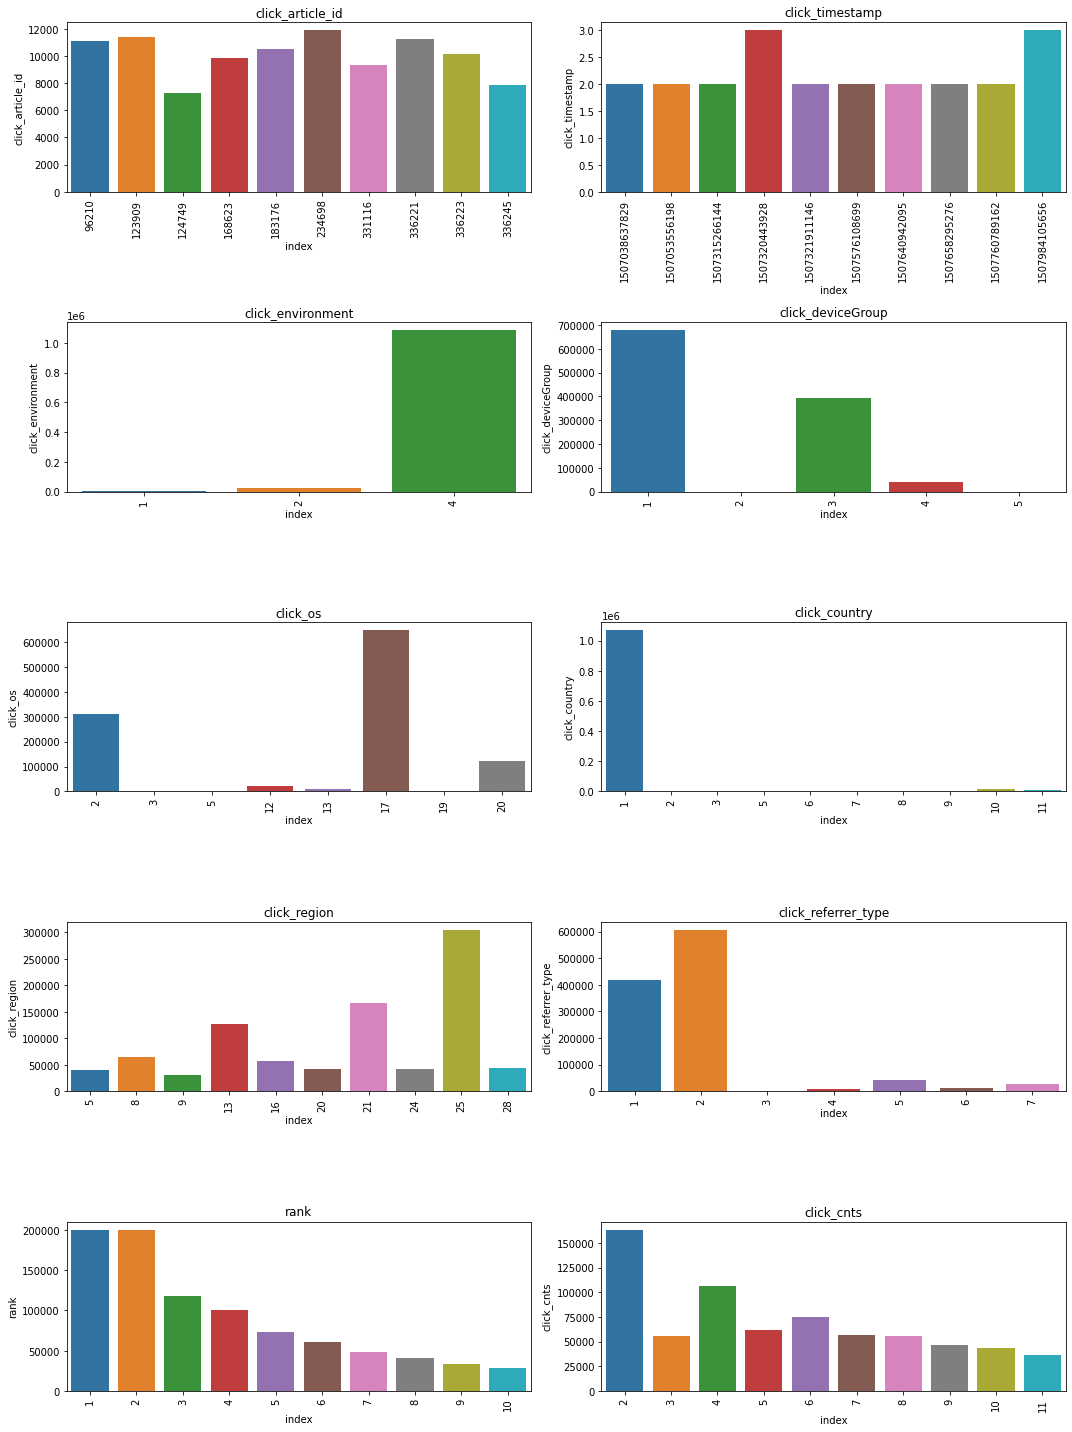

In [25]:
plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = trn_click[col].value_counts().reset_index()[:10]
    if i == 2 :
        print(v)
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

In [27]:
item_df.head()

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162


<AxesSubplot:>

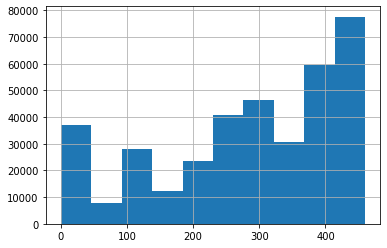

In [26]:
item_df['category_id'].hist()

<AxesSubplot:>

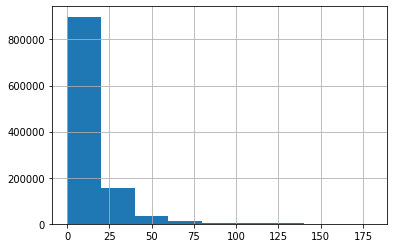

In [48]:
trn_click['click_cnts'].hist(bins=range(0,200,20))